In [17]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

np.set_printoptions(precision=3)

In [18]:
class StaticAgent:
    def __init__(self, action):
      self.action = action

    def act(self, state):
        return self.action

In [19]:
class RandomAgent:
    def __init__(self):
        pass

    def act(self, state):
        return random.randint(0, 9)

In [20]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()


    def reset(self):
        self.change_tyre(self.default_tyre)


    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)


    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00


    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

In [21]:
class Track:
    def __init__(self, opponents):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.opponents = opponents
        self.cars = [Car() for _ in range(len(self.opponents) + 1)]
        # Target agent's index
        self.target = len(self.opponents)
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()

    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.complexity = [0.00, 0.50, 1.00][np.random.randint(0, 3)]
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstops = [False for i in range(len(self.cars))]
        self.laps_cleared = 0
        self.commited_tyres = np.full_like(self.cars, -1)
        self.time_taken = np.zeros_like(self.cars)
        # self.time_taken = [Decimal(0) for _ in range(len(self.cars))]

        for car in self.cars:
          car.reset()
        return self._get_state()


    def _get_state(self):
      return self._get_states()[self.target]

    def _get_states(self):
      qualified = list(filter(lambda x: x is not None, self.time_taken))

      return [
          [
              self.cars[i].tyre,
              self.cars[i].condition,
              self.wetness[self.cur_weather],
              self.radius,
              self.laps_cleared,
              self.complexity,
              None if self.time_taken[i] is None else len(list(filter(lambda x : x < self.time_taken[i], qualified))),
              None if self.time_taken[i] is None else len(list(filter(lambda x : x > self.time_taken[i], qualified))),
          ] for i in range(len(self.cars))]

    def __calculate_reward(self):
      if self.time_taken[self.target] is None:
        return -1000000

      if self.laps_cleared < self.total_laps:
          return 0
      else:
        qualified = list(filter(lambda x: x is not None, self.time_taken))
        return [1000000, 800000, 640000, 320000][min([3, len(list(filter(lambda x : x < self.time_taken[self.target], qualified)))])]

    def transition(self, action):
        """
        Args:
            action (int):
                0. [Conservative] Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. [Conservative] Make a pitstop and fit new ‘Soft’ tyres
                2. [Conservative] Make a pitstop and fit new ‘Intermediate’ tyres
                3. [Conservative] Make a pitstop and fit new ‘Fullwet’ tyres
                4. [Conservative] Continue the next lap without changing tyres
                5. [Reckless] Make a pitstop and fit new ‘Ultrasoft’ tyres
                6. [Reckless] Make a pitstop and fit new ‘Soft’ tyres
                7. [Reckless] Make a pitstop and fit new ‘Intermediate’ tyres
                8. [Reckless] Make a pitstop and fit new ‘Fullwet’ tyres
                9. [Reckless] Continue the next lap without changing tyres
        """
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )

        states = self._get_states()
        actions = [self.opponents[i].act(states[i]) for i in range(len(self.opponents))]
        actions.append(action)

        target_velocity = None
        target_reward = None

        disqualified = False
        ## Pitstop time will be added on the first eight of the subsequent lap
        for i in range(len(actions)):
          if self.time_taken[i] is None:
            continue

          time_taken = 0
          action = actions[i]
          car = self.cars[i]
          pitstop = self.pitstops[i]
          committed_tyre = self.commited_tyres[i]
          accident_rate = 0

          if self.laps_cleared == int(self.laps_cleared):
            if pitstop:
                car.change_tyre(committed_tyre)
                time_taken += car.pitstop_time
                self.pitstops[i] = False

            # Min 1.5%, max 3%
            if action > 4:
              accident_rate += 0.015 * (1 + self.complexity)

            disqualified = np.random.rand() < accident_rate

          ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
          if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action % 5 < 4:
              self.pitstops[i] = True
              self.commited_tyres[i] = car.possible_tyres[action % 5]
            else:
              self.pitstops[i] = False

          # we assume that degration happens only after a car has travelled the one-eighth lap
          velocity = car.get_velocity()
          if action > 4:
            velocity *= 1.1
          time_taken += (2 * np.pi * self.radius / 8) / velocity
          reward = 0 - time_taken

          car.degrade(
              w = self.wetness[self.cur_weather], r=self.radius
          )

          if disqualified:
            self.time_taken[i] = None
          else:
            self.time_taken[i] += time_taken
            # self.time_taken[i] += Decimal(time_taken)

          if i == self.target:
            target_velocity = -1 if disqualified else velocity

        self.laps_cleared += 0.125

        if self.laps_cleared == self.total_laps or disqualified:
          self.is_done = True

        next_state = self._get_state()
        return self.__calculate_reward(), next_state, self.is_done, target_velocity

In [22]:
env = Track([RandomAgent()])
agent = StaticAgent(1)

In [23]:
state = env.reset()

ratio_to_wetness = {
            0.0: "Dry",  0.20: "20% Wet", 0.4: "40% Wet", 0.6: "60% Wet", 0.7: "80% Wet", 1.0: "100% Wet"
        }

start_weather, radius = ratio_to_wetness[state[2]], state[3]
    
print(state,start_weather)
done = False
G = 0
weather_seq = []
while not done:
    action = agent.act(state)
    weather_seq.append(state[2])
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward
print(state)
print("G: %d" % G)

['Intermediate', 1.0, 1.0, 654, 0, 1.0, 0, 0] 100% Wet
['Soft', 0.8238528178729371, 0.8, 654, 162.0, 1.0, 0, 0]
G: 1000000


Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 0.0, 'Ultrasoft') 20.563831229170095
(1150, 0.0, 'Ultrasoft') 19.845847518527904
(1200, 0.2, 'Ultrasoft') 19.309062686027673
(1100, 0.0, 'Ultrasoft') 19.18999437381743
(1150, 0.2, 'Ultrasoft') 18.71454467291248
(1050, 0.0, 'Ultrasoft') 18.595896846321214
(1200, 0.4, 'Ultrasoft') 18.24049804060212
(1100, 0.2, 'Ultrasoft') 18.12221989772243
(1000, 0.0, 'Ultrasoft') 18.063138842030042
(1150, 0.4, 'Ultrasoft') 17.709050236056175
(1050, 0.2, 'Ultrasoft') 17.591228214294038
(950, 0.0, 'Ultrasoft') 17.53237904729459
(1200, 0.6, 'Ultrasoft') 17.29717146327009
(1100, 0.4, 'Ultrasoft') 17.238461535010163
(1000, 0.2, 'Ultrasoft') 17.121085472342063
(900, 0.0, 'Ultrasoft') 17.003827314845424
(1150, 0.6, 'Ultrasoft') 16.828189068424955
(1050, 0.4, 'Ultrasoft') 16.71123816495243
(950, 0.2, 'Ultrasoft') 16.65283229934356
(850, 0.0, 'Ultrasoft') 16.53607473317711
(1200, 0.8, 'Ultrasoft') 16.477767243435533
(1100, 0.6, 'Ultrasoft')

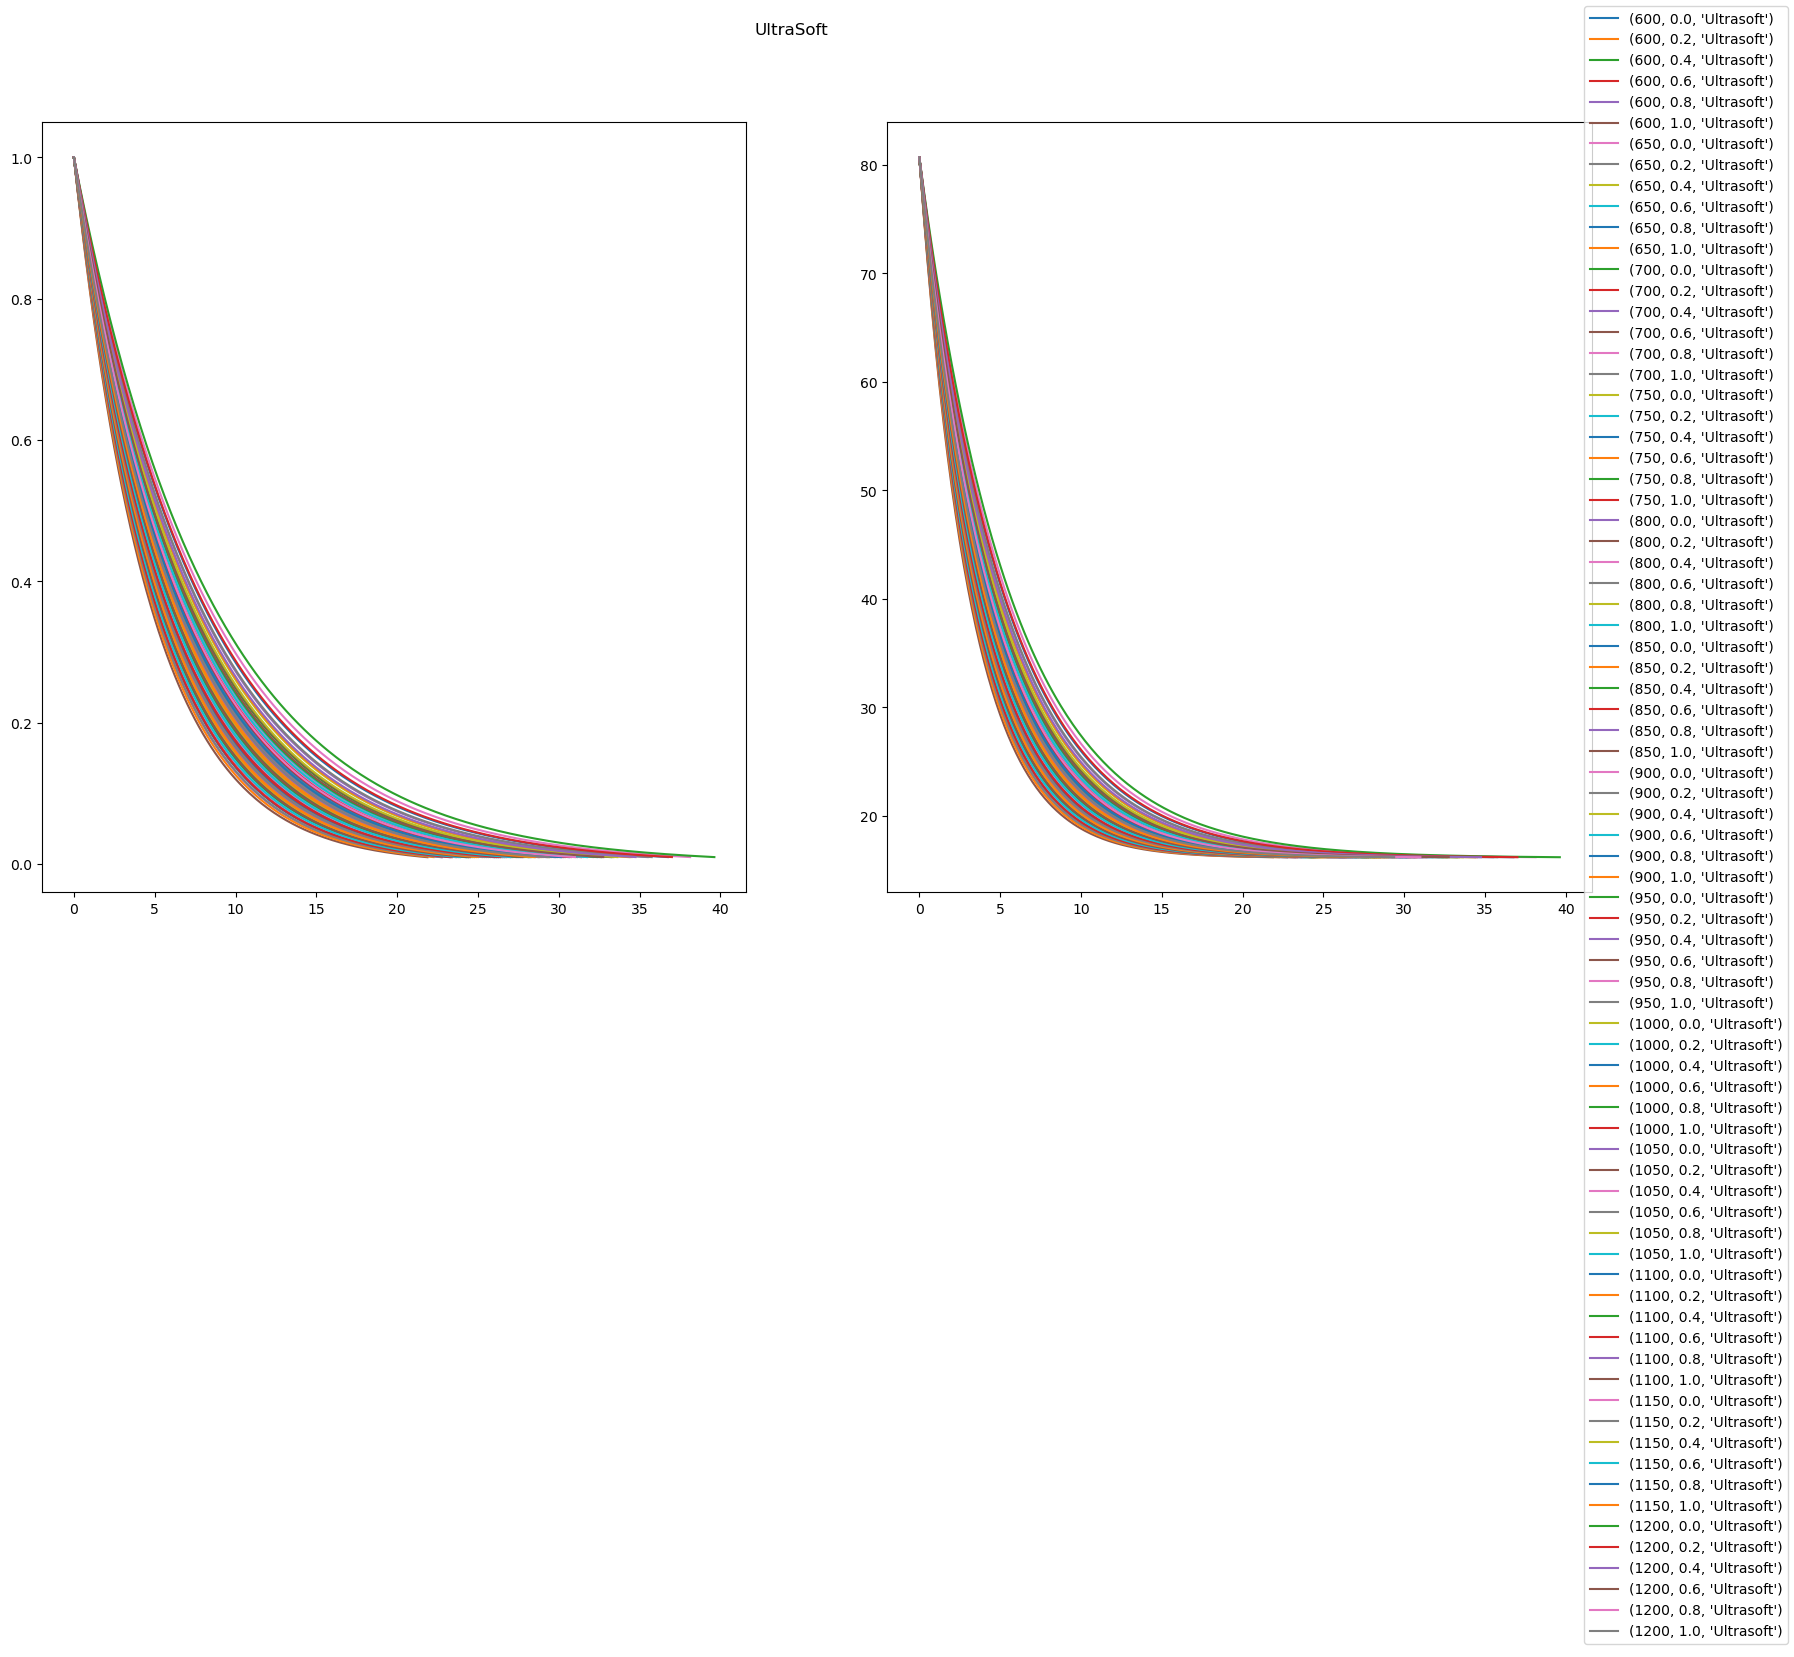

In [24]:
all_tyre_durability = {}
all_tyre_conditions = []
## Compute tire durability
'''
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
self.wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}

To compute tire durability, we first:
- Take each tyre compound and let it run for 162 laps over various 
    - wetness
    - radius : 600m - 1200m

Degradation Function:
def degrade(self, w, r):
    if self.tyre == "Ultrasoft":
        self.condition *= (1 - 0.0050*w - (2500-r)/90000)
    elif self.tyre == "Soft":
        self.condition *= (1 - 0.0051*w - (2500-r)/93000)
    elif self.tyre == "Intermediate":
        self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
    elif self.tyre == "Fullwet":
        self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)

Final Rollout Policy:
The rollout policy that takes advantage of these durabilities works as follows.
When the current tire set has reached its expected duration, the pit stop is 
performed with a probability of 0.9, or the decision is deferred by one lap with a
probability of 0.1. 

The choice of the next compound to use is deterministic: 
if there are any compounds whose durability would cover the remainder of the race, 
the policy suggests fitting the softest one among them. If there is no such
compound, the softest compound available is fitted instead

'''
import matplotlib.pyplot as plt
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Ultrasoft
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('UltraSoft')

for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 80.7
        velocities = [80.7]
        
        lap_count = 0
        lap = [0]
        w = weather
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0050*w - (2500-r)/90000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 80.7*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Ultrasoft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Ultrasoft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Ultrasoft"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])  

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 0.0, 'Soft') 21.218196033510914
(1150, 0.0, 'Soft') 20.437901697550082
(1200, 0.2, 'Soft') 19.83955810553273
(1100, 0.0, 'Soft') 19.77982225253882
(1150, 0.2, 'Soft') 19.24303048392042
(1050, 0.0, 'Soft') 19.183484053664262
(1200, 0.4, 'Soft') 18.707845134444508
(1100, 0.2, 'Soft') 18.64848651154781
(1000, 0.0, 'Soft') 18.58914986299824
(1150, 0.4, 'Soft') 18.11527053077105
(950, 0.0, 'Soft') 18.056163832052125
(1050, 0.2, 'Soft') 18.056142513923533
(1100, 0.4, 'Soft') 17.642983563534646
(1200, 0.6, 'Soft') 17.64296220321823
(1000, 0.2, 'Soft') 17.584059014534873
(900, 0.0, 'Soft') 17.525161179391684
(1150, 0.6, 'Soft') 17.172368055210836
(950, 0.2, 'Soft') 17.11368729732815
(1050, 0.4, 'Soft') 17.113665967525876
(850, 0.0, 'Soft') 17.05501456888361
(1200, 0.8, 'Soft') 16.762117558009535
(1000, 0.4, 'Soft') 16.7036491363583
(1100, 0.6, 'Soft') 16.703627765795318
(900, 0.2, 'Soft') 16.645191224231983
(800, 0.0, 'Sof

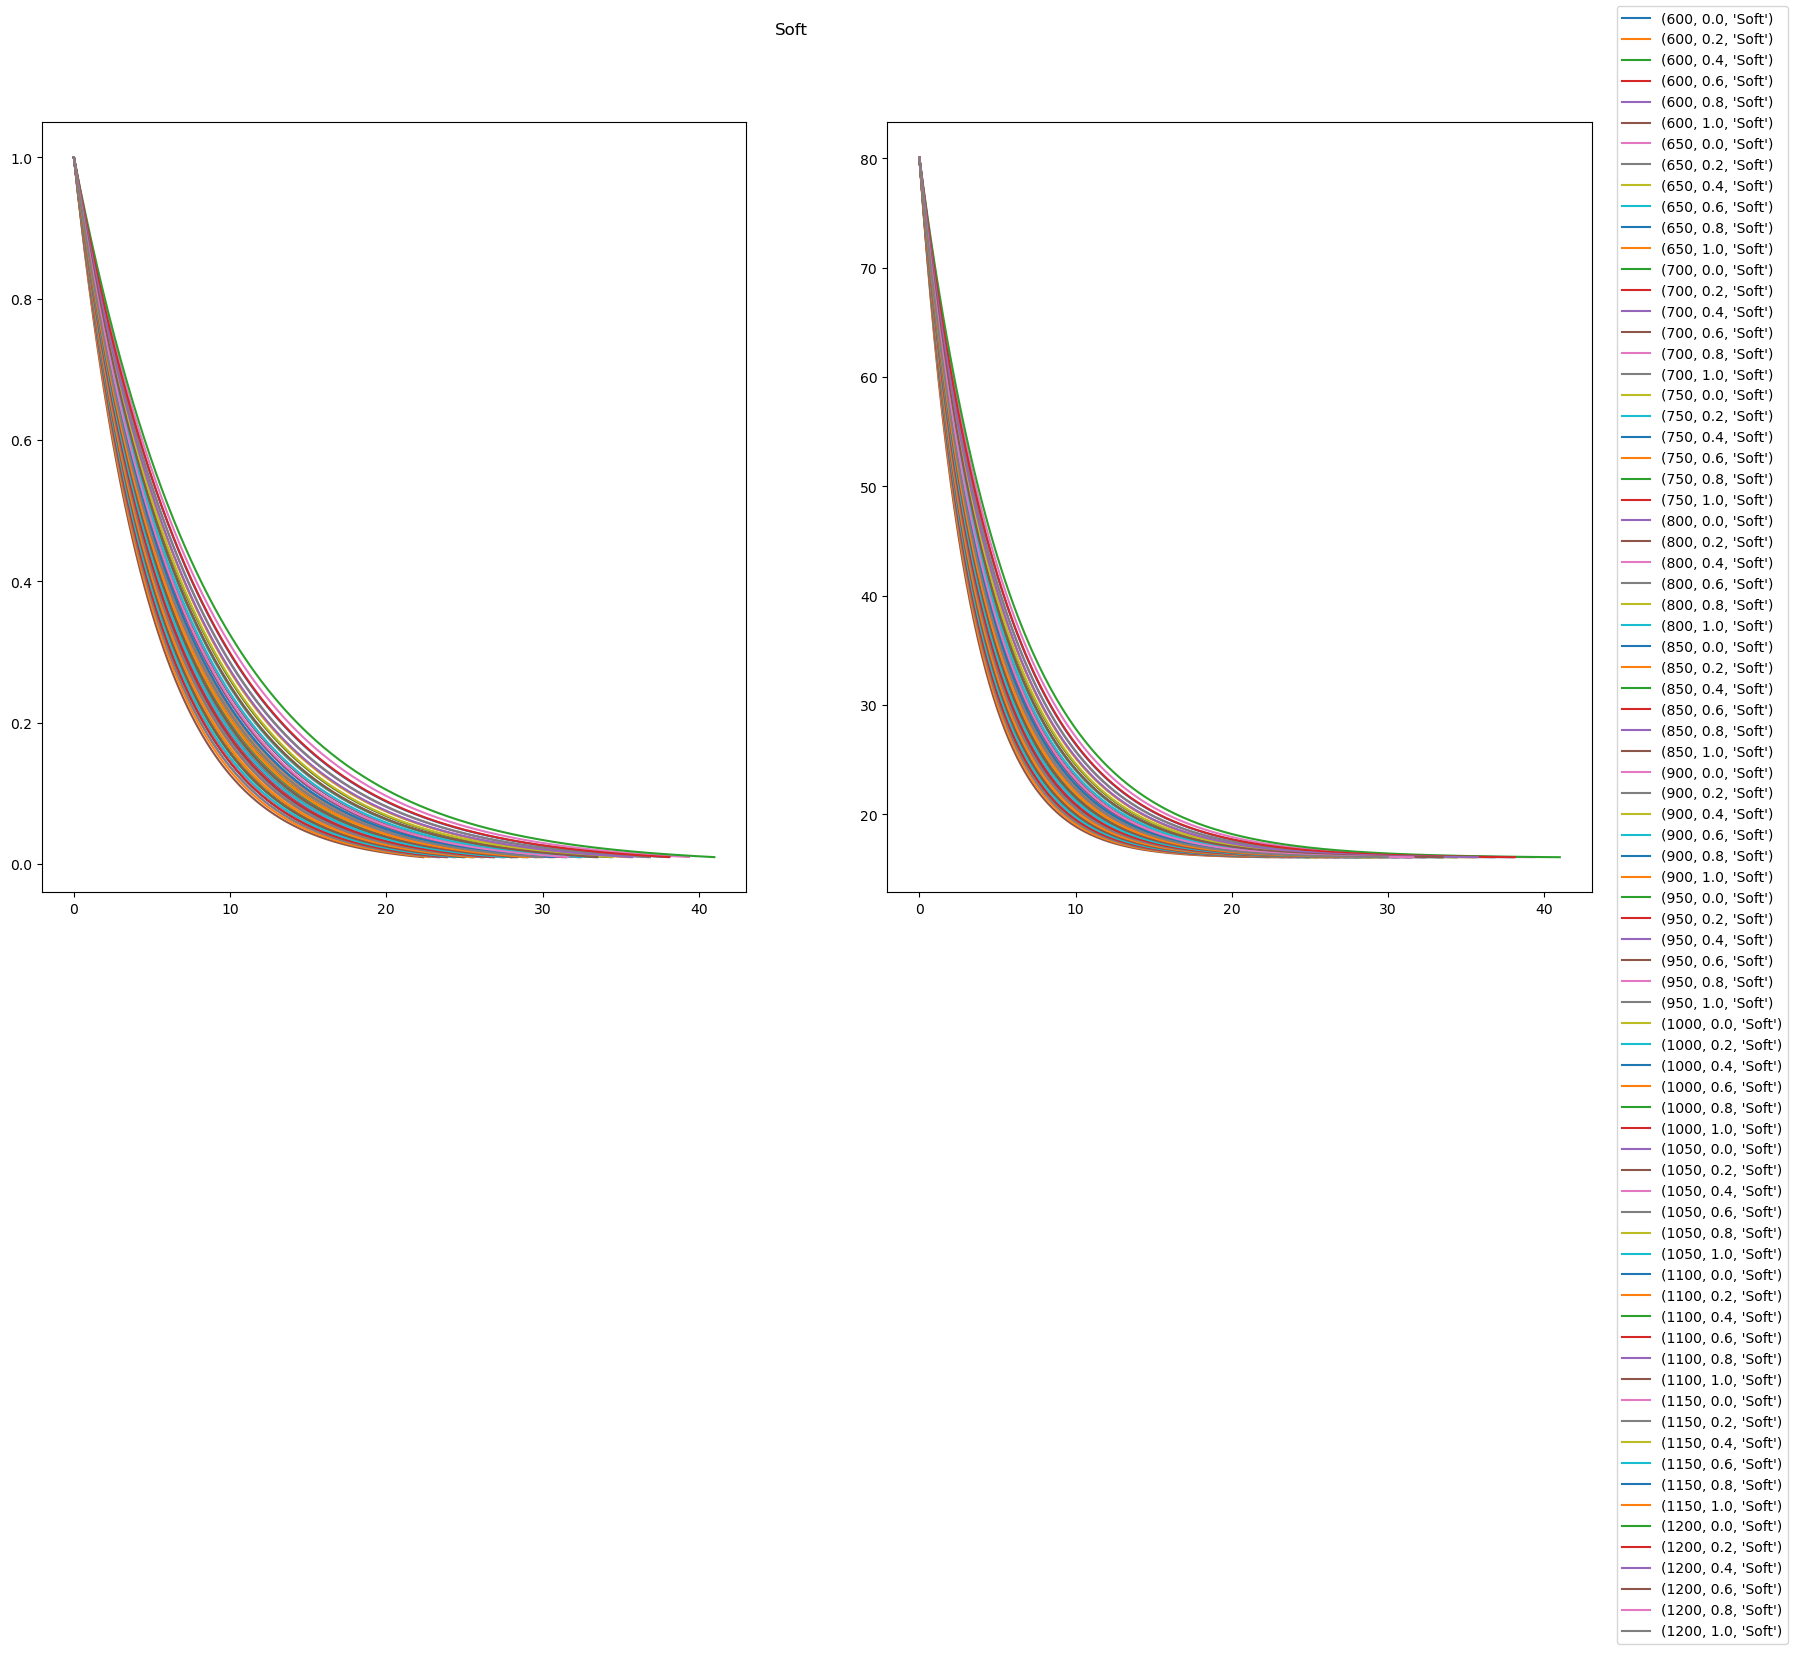

In [25]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# soft
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Soft')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 80.1
        velocities = [80.1]
        
        lap_count = 0
        lap = [0]
        w = weather
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0051*w - (2500-r)/93000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 80.1*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Soft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Soft")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather,"Soft"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 0.4, 'Intermediate') 20.851773683205177
(1200, 0.6, 'Intermediate') 20.851773683205177
(1150, 0.4, 'Intermediate') 20.192200724139802
(1150, 0.6, 'Intermediate') 20.192200724139802
(1100, 0.4, 'Intermediate') 19.534661055489636
(1100, 0.6, 'Intermediate') 19.534661055489636
(1200, 0.2, 'Intermediate') 19.53465619889716
(1200, 0.8, 'Intermediate') 19.53465619889716
(1050, 0.4, 'Intermediate') 18.938875187959745
(1050, 0.6, 'Intermediate') 18.938875187959745
(1150, 0.2, 'Intermediate') 18.93887033864896
(1150, 0.8, 'Intermediate') 18.93887033864896
(1000, 0.4, 'Intermediate') 18.40445364755631
(1000, 0.6, 'Intermediate') 18.40445364755631
(1100, 0.2, 'Intermediate') 18.404448847640744
(1100, 0.8, 'Intermediate') 18.404448847640744
(1200, 0.0, 'Intermediate') 18.404444021737575
(1200, 1.0, 'Intermediate') 18.404444021737575
(950, 0.4, 'Intermediate') 17.87187709297003
(950, 0.6, 'Intermediate') 17.87187709297003
(1050

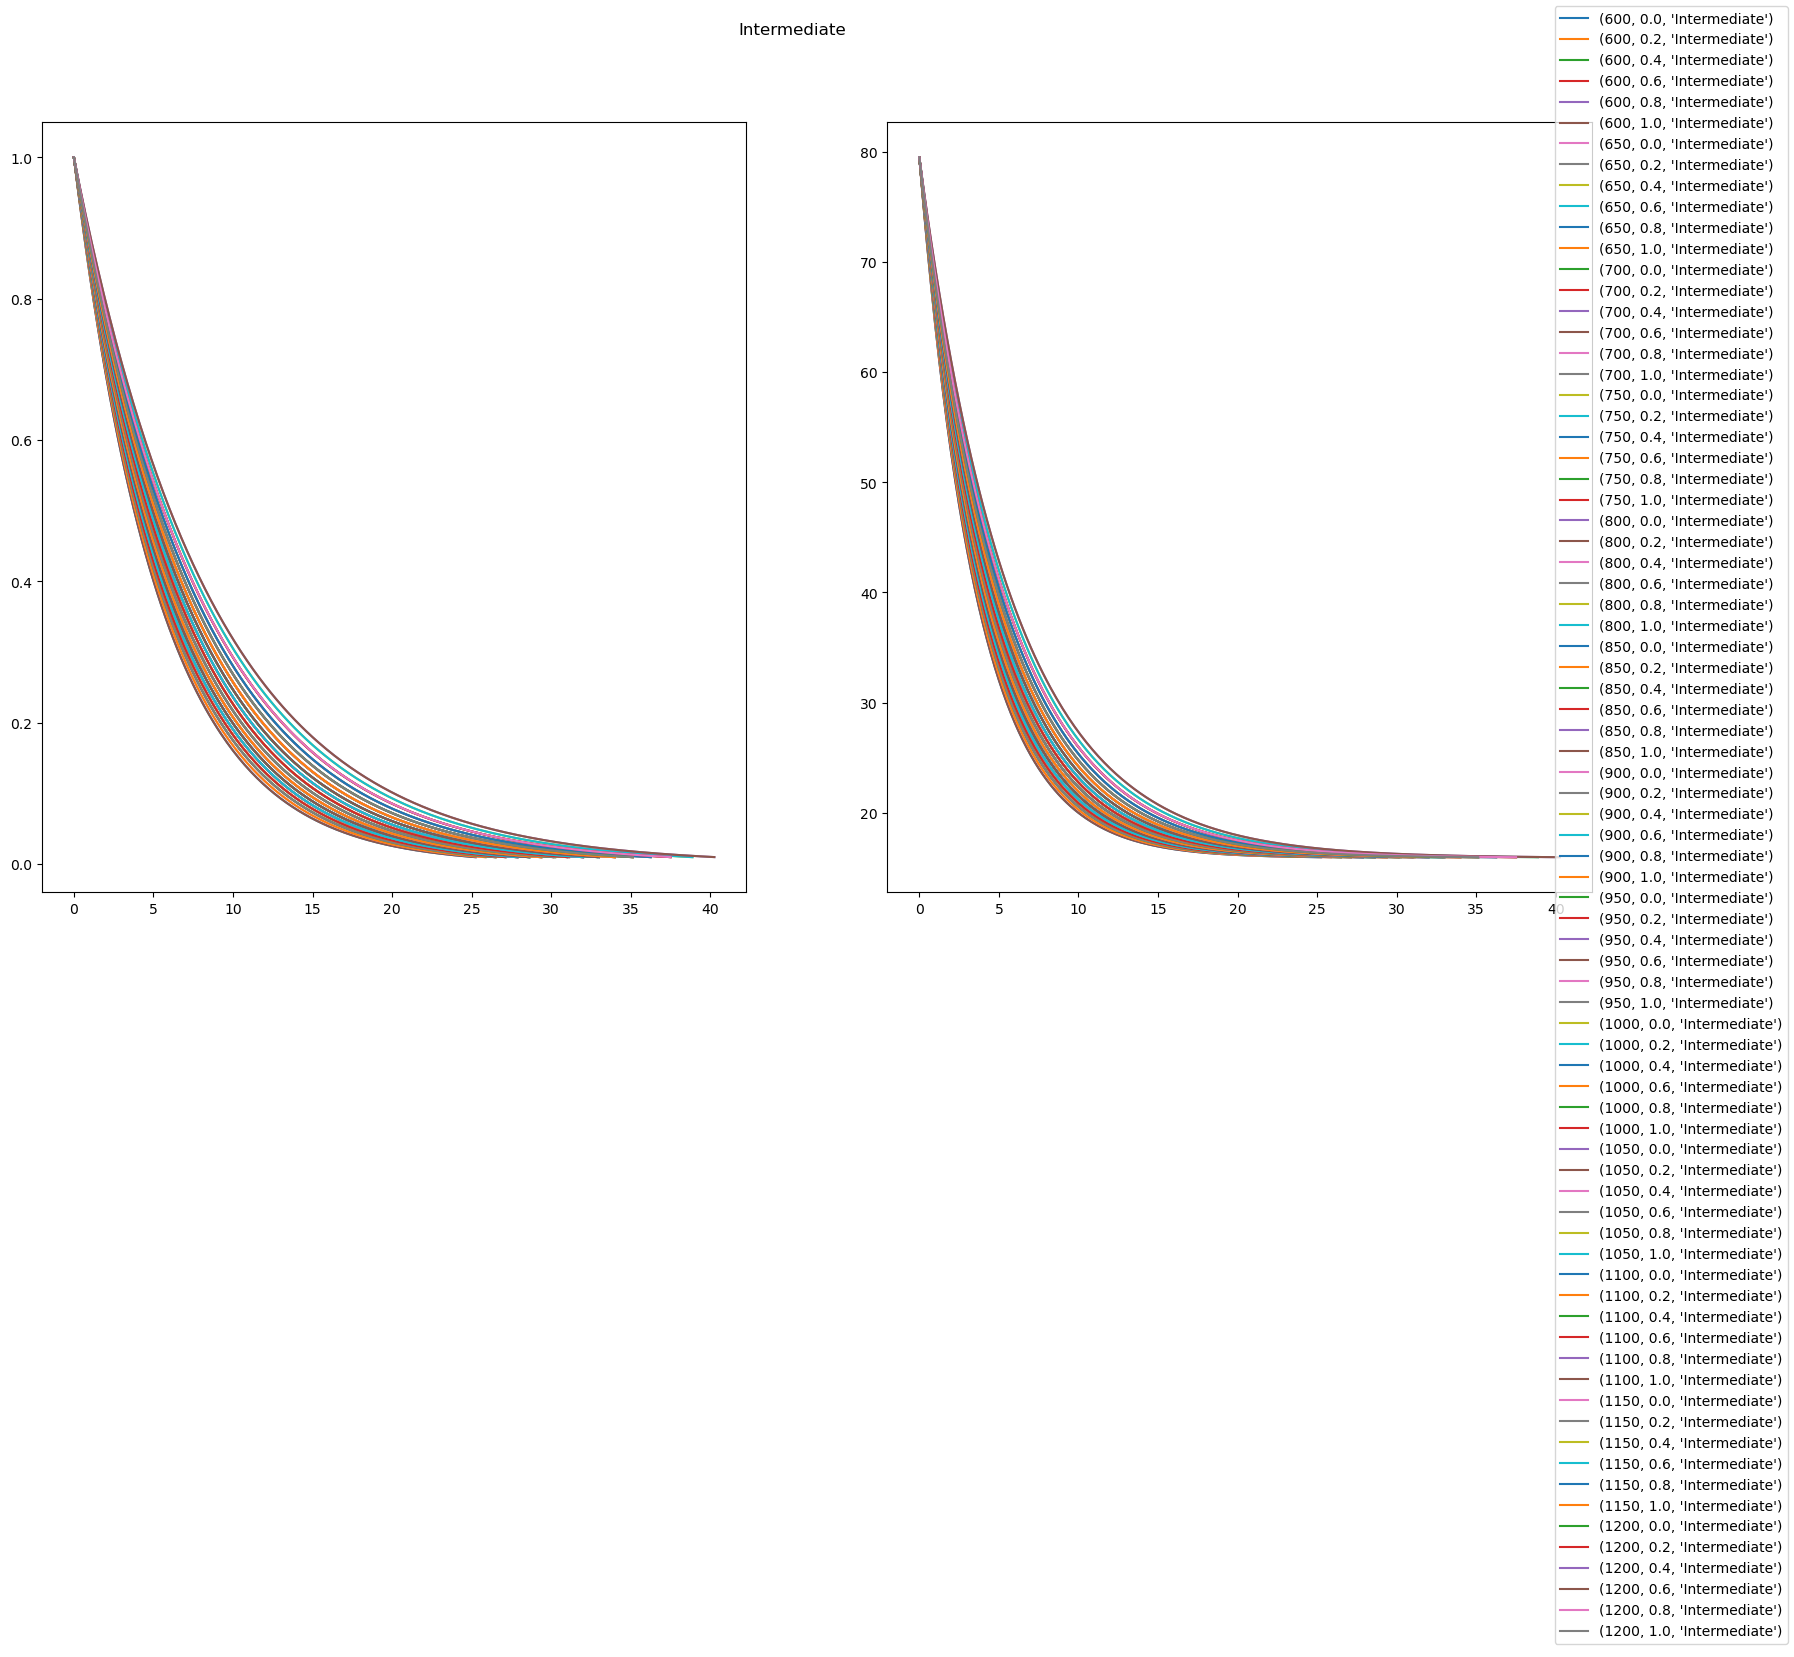

In [26]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# intermediate
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Intermediate')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 79.5
        velocities = [79.5]
        
        lap_count = 0
        lap = [0]
        w = weather
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 79.5*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "Intermediate")] =0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "Intermediate")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Intermediate"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i])  

Durability from Highest Number of Laps to Lowest Number of Laps:
(1200, 1.0, 'FullWet') 22.05095237410584
(1150, 1.0, 'FullWet') 21.267627390716008
(1200, 0.8, 'FullWet') 20.54669400287321
(1100, 1.0, 'FullWet') 20.54668295212111
(1150, 0.8, 'FullWet') 19.887833140354747
(1050, 1.0, 'FullWet') 19.88782208389371
(1000, 1.0, 'FullWet') 19.290710073719108
(1200, 0.6, 'FullWet') 19.2311046424955
(1100, 0.8, 'FullWet') 19.231093534808398
(1050, 0.8, 'FullWet') 18.69554570645693
(950, 1.0, 'FullWet') 18.69553460449595
(1150, 0.6, 'FullWet') 18.636133942653892
(1000, 0.8, 'FullWet') 18.16173659101864
(900, 1.0, 'FullWet') 18.161725483801693
(1200, 0.4, 'FullWet') 18.1025395188698
(1100, 0.6, 'FullWet') 18.102528405505634
(850, 1.0, 'FullWet') 17.688851121336995
(1150, 0.4, 'FullWet') 17.62986348331197
(1050, 0.6, 'FullWet') 17.62985247792046
(950, 0.8, 'FullWet') 17.62984134122374
(900, 0.8, 'FullWet') 17.217638658183606
(800, 1.0, 'FullWet') 17.217627661686002
(1100, 0.4, 'FullWet') 17.15885

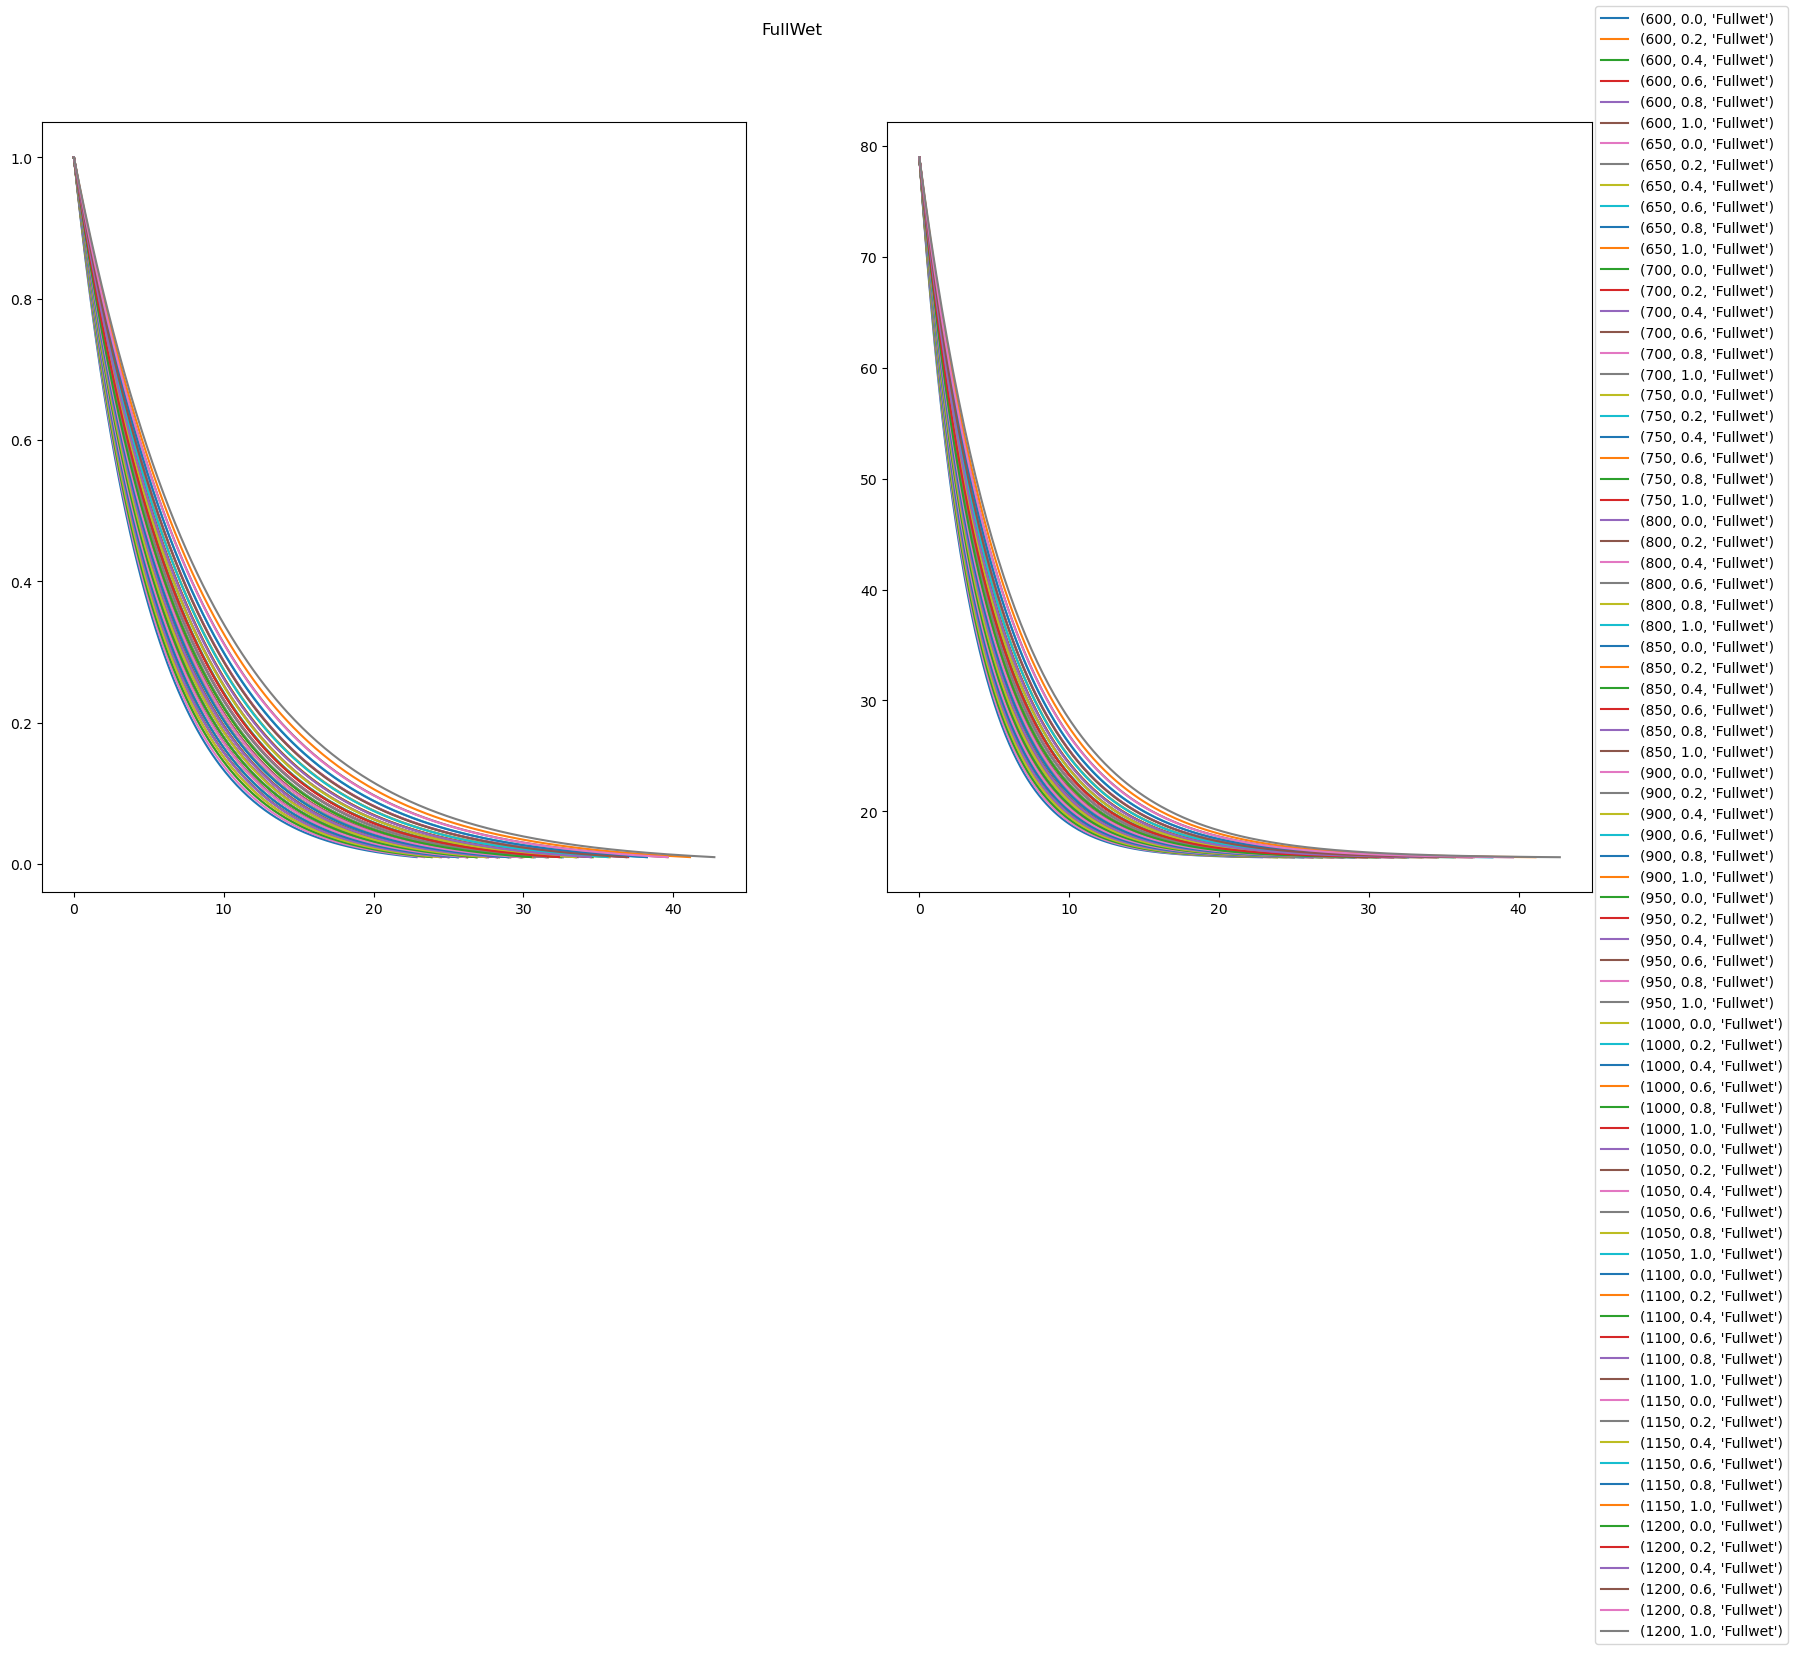

In [27]:
wetness = {
    "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
}
possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
possible_weather = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# fullwet
legend = []
lap_at_zero_condition = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('FullWet')
for r in range(600, 1250, 50):
    for weather in possible_weather:
        condition = 1
        condition_values_ultrasoft = [1]
        
        velocity = 79.0
        velocities = [79.0]
        
        lap_count = 0
        lap = [0]
        w = weather
        while lap_count != 162 and condition > 0.005:
            condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
            condition_values_ultrasoft.append(round(condition,8))
            all_tyre_conditions.append(round(condition,8))
            
            velocity = 79.0*(0.2 + 0.8*condition**1.5)
            velocities.append(velocity)
            
            lap_count += 0.125
            lap.append(lap_count)
            if condition < 0.01:
                lap_at_zero_condition[(r,weather, "FullWet")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                all_tyre_durability[(r,weather, "FullWet")] = 0.5 * (lap_count -0.125 ) + 0.5 * ((velocities[0]-velocities[-1])/lap_count)
                break
        # create some x data and some integers for the y axis
        x = np.array(lap)
        y = np.array(condition_values_ultrasoft)
        z = np.array(velocities)
        # plot the data
        ax1.plot(x, y)
        ax2.plot(x, z)
        legend.append((r,weather, "Fullwet"))
        
fig.legend(legend)

print("Durability from Highest Number of Laps to Lowest Number of Laps:")
list_of_laps = sorted(lap_at_zero_condition, key=lap_at_zero_condition.get, reverse=True)
# print(list_of_laps)

for i in list_of_laps:
    print(i, lap_at_zero_condition[i]) 

In [28]:
list_of_laps = sorted(all_tyre_durability, key=all_tyre_durability.get, reverse=True)
# print(list_of_laps)

final_dict_tyre = {}
for i in list_of_laps:
    print(i, all_tyre_durability[i])
    final_dict_tyre[i] = all_tyre_durability[i]

(1200, 1.0, 'FullWet') 22.05095237410584
(1150, 1.0, 'FullWet') 21.267627390716008
(1200, 0.0, 'Soft') 21.218196033510914
(1200, 0.4, 'Intermediate') 20.851773683205177
(1200, 0.6, 'Intermediate') 20.851773683205177
(1200, 0.0, 'Ultrasoft') 20.563831229170095
(1200, 0.8, 'FullWet') 20.54669400287321
(1100, 1.0, 'FullWet') 20.54668295212111
(1150, 0.0, 'Soft') 20.437901697550082
(1150, 0.4, 'Intermediate') 20.192200724139802
(1150, 0.6, 'Intermediate') 20.192200724139802
(1150, 0.8, 'FullWet') 19.887833140354747
(1050, 1.0, 'FullWet') 19.88782208389371
(1150, 0.0, 'Ultrasoft') 19.845847518527904
(1200, 0.2, 'Soft') 19.83955810553273
(1100, 0.0, 'Soft') 19.77982225253882
(1100, 0.4, 'Intermediate') 19.534661055489636
(1100, 0.6, 'Intermediate') 19.534661055489636
(1200, 0.2, 'Intermediate') 19.53465619889716
(1200, 0.8, 'Intermediate') 19.53465619889716
(1200, 0.2, 'Ultrasoft') 19.309062686027673
(1000, 1.0, 'FullWet') 19.290710073719108
(1150, 0.2, 'Soft') 19.24303048392042
(1200, 0.6, 

In [29]:
class MonteCarloTreeSearchNodeMod():
  def __init__(self, Env, state, parent=None, parent_action=None, reward=0, q_value=0, prev_action=None, timesteps=0):
    #node 
    self.parent = parent
    self.parent_action = parent_action
    self.reward = reward
    self.q_value = q_value
    self.children = []
    self.timesteps = timesteps
    
    #actions
    self.legal_actions = [0,1,2,3,4,5,6,7,8,9]
    
    #state
    self.state = state
    
    #environment factors
    self.ratio_to_wetness = {
      0.0: "Dry",  0.20: "20% Wet", 0.4: "40% Wet", 0.6: "60% Wet", 0.8: "80% Wet", 1.0: "100% Wet"
    }
    self.env = Env
    self.env.cars[self.env.target].tyre = state[0]
    self.env.cars[self.env.target].condition = state[1]
    self.env.cur_weather = self.ratio_to_wetness[state[2]]
    self.env.radius = state[3]
    self.env.is_done =state[4] == 162
    self.env.laps_cleared = state[4]
    
    self.original_pitstop = Env.pitstops[Env.target]
    
    #keep track of previous actions and current pitstop
    self.prev_action = prev_action
    self.current_pitstop = self.env.pitstops[Env.target]
    
    # params
    self.discount_rate = 0.90
    self.lr = 0.1
    
    #to account for radius, we have to weigh future q value vs instant rewards
    # i.e. 0.2*i.q_value + 0.8*i.reward
    # self.weight_future_q = 0.75
    # self.weight_future_q = 0.5
    self.weight_future_q = ((1-(state[3]-600)/600)) #for shorter races, we want fewer pitstops, so we look more at future rewards
    if self.weight_future_q <= 0.25:
      self.weight_future_q = 0.15
    elif self.weight_future_q > 0.25 and self.weight_future_q <= 0.75:
      self.weight_future_q = 0.35
    
  def best_action(self):
    # at 3/4 mark, run simulations
    if self.state[4] - int(self.state[4]) == 0.75:
      simulation_no = 10
      for i in range(simulation_no):
        # tree policy gets all unexplored states first
        # After exploring all states, it explores with a decaying epsilon the same states again with different paths
        # updates the 4 action Q values
        v = self.tree_policy()
        
        #once we have a child node
        cum_discounted_rewards = v.rollout()
        
        # after getting cum discounted rewards, we backpropagate to store results
        v.backpropagate(cum_discounted_rewards)
        
        #reset for next step
        self.env.cars[self.env.target].tyre = self.state[0]
        self.env.cars[self.env.target].condition = self.state[1]
        self.env.cur_weather = self.ratio_to_wetness[self.state[2]]
        self.env.radius = self.state[3]
        self.env.is_done = False
        self.env.laps_cleared = self.state[4]
      
      self.env.pitstops[self.env.target] = self.original_pitstop
      result = self.overall_best_child()
      
      # for i in self.children:
      #   print("CHILD:", i.q_value, i.state, i.reward, i.timesteps, (self.weight_future_q)*i.q_value + (1-self.weight_future_q)*i.reward)

      return result
    else:
      #if original pitstop is false, means no change in action
      if self.current_pitstop == False or self.prev_action == None:
        return 4 #action 4 = do nothing
      
      #if original pitstop is True
      if self.current_pitstop:
        return self.prev_action
      
  def tree_policy(self):
    current_node = self
    
    #terminal node = lap 162
    while not current_node.is_terminal_node():
      
      # explore the unexplored actions
      if not current_node.is_fully_expanded():
        return current_node.expand()
      else:
        # with epsilon decay, try to explore new states
        return current_node.best_child()

  def is_terminal_node(self):
    if self.state[4] == 162:
      return True
    return False
  
  def is_fully_expanded(self):
    return len(self.legal_actions) == 0  

  def expand(self):
    action = self.legal_actions.pop()
    
    # do a look ahead for the next x num of laps and stick to one action
    lookahead_laps = 1/8
    
    #compute q value for lookahead
    done = False
    total_rewards= 0
    for i in range(int(lookahead_laps*8)): #10 * 8 since each lap has 8 parts
      if done:
        break
      else:
        reward, next_state, done, velocity = self.env.transition(action)
        total_rewards += reward
    
    # we want to simulate our next state to be a varied tyre choice
    next_state[4] = self.state[4] + 0.125
    
    # add child nodes to current state
    child_node = MonteCarloTreeSearchNodeMod(Env=self.env, state=next_state, parent=self, parent_action=action,
                                             reward=total_rewards, q_value=0)
    self.children.append(child_node)
    return child_node  
  
  # after expanding an unexplored action, we rollout to terminal state
  def rollout(self):
    current_rollout_state = self.state  
    
    # get a list of rewards
    reward_list = []
    while not current_rollout_state[4] == 162:
      action = self.rollout_policy(current_rollout_state)
      reward, current_rollout_state, done, velocity = self.env.transition(action)
      reward_list.append(reward)
    
    # discount from terminal node
    reward_list = reward_list[::-1]
    # print("TOTAL rewards", sum(reward_list), len(reward_list), self.parent_action, current_rollout_state)
    discounted_rewards_all_other_states = 0
    for r in reward_list:
      # generate all discounted rewards
      discounted_rewards_all_other_states = self.discount_rate * discounted_rewards_all_other_states + r

    # print(self.state, self.reward, discounted_rewards_all_other_states)
    # add the current rewards from change
    discounted_rewards_all_other_states += self.reward

    # we need to reset the pitstop to False at this stage before we actually play the moves
    self.env.pitstops[self.env.target] = False
    self.q_value = (self.q_value*self.timesteps + discounted_rewards_all_other_states)/(self.timesteps+1)
    return discounted_rewards_all_other_states
  
  # rollout policy depends on durability and rate of loss in velocity and picks the next set of tyres based on that
  def rollout_policy(self, curr_state):
    '''
    If durability condition 
    '''
    speed_tyre = {"Ultrasoft": 80.7, "Soft": 80.1, "Intermediate": 79.5, "Fullwet": 79.0}
    conservative_velocity = speed_tyre[curr_state[0]]*(0.2 + 0.8*curr_state[1]**1.5)
    
    #favourable weather for specific tyre
    fav_weather_tyre = {
      "Ultrasoft": [0.0, 0.2],
      "Soft": [0.2],
      "Intermediate": [0.4, 0.6, 0.8],
      "Fullwet": [0.8, 1.0]
    }
    
    # curr_time_taken_per_lap = (2*np.pi*curr_state[-2] / conservative_velocity)
    curr_time_taken_per_lap = (curr_state[3] / conservative_velocity)
    
    # time taken per lap is more than 14 or car condition is less than 0.3
    if curr_time_taken_per_lap > (1.5* 23): # or curr_state[1]< 0.05:
      epsilon_for_change = random.random()
      nearest_fifty_radius = 50 * round(curr_state[3]/50)
      
      # #create function to adjust probability for change to account for radius
      # # larger radius should have larger probability of change as next change is much longer later
      # # account for how long is one round, 
      # # if one round gets closer to 1.5 times of pitstop time, do change
      # epsilon_threshold = radius_to_probability_change[nearest_fifty_radius]
      # max_epsilon_threshold = 0.9999
      curr_threshold = 0.5
      
      #if favourable weather for specific tyre set, reduce possibility of change
      if curr_state[2] in fav_weather_tyre[curr_state[0]]:
        # if radius is larger, change tyre with higher probability even if tyre i favourbale
        curr_threshold -= (0.45 * (1-(curr_state[3]-600)/600))
      else:
        #if weather is unfavourable, increase probability to change tyre
        # if radius is smaller, let the tyre run a little longer
        curr_threshold += (0.45 * ((curr_state[3]/600)-1))
      
      # if epsilon_for_change <= 0.999:
      if epsilon_for_change <= curr_threshold:
        
        filtered_durability = {
          (nearest_fifty_radius, curr_state[2], "Ultrasoft"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Ultrasoft")],
          (nearest_fifty_radius, curr_state[2], "Soft"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Soft")],
          (nearest_fifty_radius, curr_state[2], "Intermediate"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "Intermediate")],
          (nearest_fifty_radius, curr_state[2], "FullWet"): final_dict_tyre[(nearest_fifty_radius, curr_state[2], "FullWet")]
        }
        highest_durability = sorted(filtered_durability, key=filtered_durability.get, reverse=True)
        if highest_durability[0][-1] == "Ultrasoft":
          if random.random() > 0.1:
            return 0
          else:
            return 5
        elif highest_durability[0][-1] == "Soft":
          if random.random() > 0.1:
            return 1
          else:
            return 6
        elif highest_durability[0][-1] == "Intermediate":
          if random.random() > 0.1:
            return 2
          else:
            return 7
        elif highest_durability[0][-1] == "FullWet":
          if random.random() > 0.1:
            return 3
          else:
            return 8
      else:
        if random.random() > 0.1:
          return 4
        else:
          return 9
    else:
      # do not change
      if random.random() > 0.3:
        return 4
      else:
        return 9
    
  def backpropagate(self, cum_discounted_rewards):
    parent = self.parent
    self.timesteps += 1
    
    while self.parent is not None:
      # all are leaf nodes since we only expand one level down
      parent.q_value = parent.q_value + self.lr * (parent.reward + self.discount_rate * cum_discounted_rewards - parent.q_value)
      parent.timesteps+=1
      self = parent
      parent = self.parent
      
  def best_child(self):
    # instead of using UCB, we use epsilon with decaying factor to generate more samples
    choices_weights = [c.q_value for c in self.children]
    get_random = random.randint(0,len(choices_weights)-1)
    #epsilon greedy with decay
    if random.random() <= max(0.5, (self.state[4])/162):
      return self.children[np.argmax(choices_weights)]
    else:
      return self.children[get_random]
    
  def overall_best_child(self):
    # if 3/4 mark is reached, able to change action based on argmax
    choices_weights = [ (self.weight_future_q)*c.q_value + (1-self.weight_future_q)*c.reward for c in self.children]
    # print(choices_weights)
    return int(4-np.argmax(choices_weights))
    
    

In [30]:
def q_learning_open_loop_planning(input_state, prev_action):
  root = MonteCarloTreeSearchNodeMod(Env= env, state = input_state, prev_action=prev_action)
  selected_node = root.best_action()
  return selected_node

In [31]:
env = Track([RandomAgent()])
group1 = StaticAgent(1)
group2 = StaticAgent(1)
group3 = StaticAgent(1)
group4 = StaticAgent(1)
group5 = StaticAgent(1)

In [32]:
# Monte Carlo Tree Search
ratio_to_wetness = {
    0.0: "Dry",  0.20: "20% Wet", 0.4: "40% Wet", 0.6: "60% Wet", 0.8: "80% Wet", 1.0: "100% Wet"
}
for agent in [group1, group2, group3, group4, group5]:
    state = env.reset() 
    env.cur_weather = start_weather   # assert common start weather
    env.radius = radius               # assert common track radius
    done = False
    G = 0
    i = 0
    
    input_state = env._get_state()
    print(input_state, start_weather)
    action = 4
    while not done:
        env.cur_weather = str(ratio_to_wetness[weather_seq[i]])   # assert weather transition
        action = q_learning_open_loop_planning(input_state=input_state, prev_action=action)
        reward, next_state, done, velocity = env.transition(action)
        
        # print("FINALLLL:", next_state, velocity, "action is: ", action,  "  Total returns: ", G, reward)
        input_state = deepcopy(next_state)
        G += reward
        i += 1
    print("MCTS G: %.2f" % G)

['Intermediate', 1.0, 1.0, 654, 0, 0.5, 0, 0] 100% Wet
MCTS G: -1290000000.00
['Intermediate', 1.0, 1.0, 654, 0, 0.0, 0, 0] 100% Wet
MCTS G: -1290000000.00
['Intermediate', 1.0, 1.0, 654, 0, 1.0, 0, 0] 100% Wet
